In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
from os import listdir
from os.path import isfile, join
from matplotlib.ticker import MultipleLocator


['11-08-26.csv']


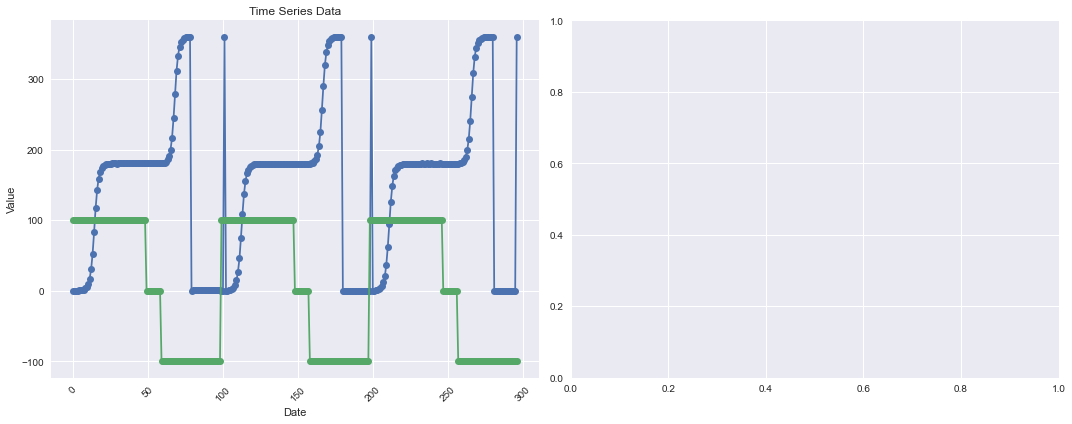

In [54]:
path = '/Users/alexleffell/Documents/PhD/tplax/Data/112024_Vel_L15_R10_S1/2024/Nov/20/'

# Set the style for better-looking plots
plt.style.use('seaborn')

# Read the CSV file
# Replace 'your_file.csv' with your actual file name
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
print(onlyfiles)
df = pd.read_csv(path+onlyfiles[0])

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Line plot
# Assuming your CSV has 'date' and 'value' columns
ax1.plot(df['Test Grid/Caster Angle'], marker='o')
ax1.plot(100*df['Test Grid/Output'], marker='o')
ax1.set_title('Time Series Data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value')
ax1.tick_params(axis='x', rotation=45)



# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

In [45]:
y = df['Test Grid/Caster Angle']

In [131]:
def fit_exponential(x, y, yerr=None, offset_type='both', method='curve_fit', plot=True):
    """
    Fit an exponential curve with optional x and y offsets.
    
    Parameters:
    -----------
    x : array-like
        Independent variable values
    y : array-like
        Dependent variable values
    yerr : array-like, optional
        Uncertainties in y values
    offset_type : str
        'none': y = a*exp(b*x)
        'y': y = a*exp(b*x) + y0
        'x': y = a*exp(b*(x-x0))
        'both': y = a*exp(b*(x-x0)) + y0
    method : str
        'curve_fit' or 'log' for fitting method
    plot : bool
        Whether to plot the results
    
    Returns:
    --------
    tuple
        Fit parameters and R-squared value
    """
    x = np.array(x)
    y = np.array(y)
    
    # Define different exponential functions based on offset type
    def exp_func_no_offset(x, a, b):
        return a * np.exp(b * x)
    
    def exp_func_y_offset(x, a, b, y0):
        return a * np.exp(b * x) + y0
    
    def exp_func_x_offset(x, a, b, x0):
        return a * np.exp(b * (x - x0))
    
    def exp_func_both_offset(x, a, b, x0, y0):
        return a * np.exp(b * (x - x0)) + y0
    
    # Select appropriate function and make initial parameter guesses
    if offset_type == 'none':
        exp_func = exp_func_no_offset
        p0 = [y[0], (np.log(y[-1]) - np.log(y[0])) / (x[-1] - x[0])]
    elif offset_type == 'y':
        exp_func = exp_func_y_offset
        p0 = [y[0], (np.log(y[-1]) - np.log(y[0])) / (x[-1] - x[0]), min(y)]
    elif offset_type == 'x':
        exp_func = exp_func_x_offset
        p0 = [y[0], (np.log(y[-1]) - np.log(y[0])) / (x[-1] - x[0]), x[0]]
    elif offset_type == 'both':
        exp_func = exp_func_both_offset
        p0 = [y[0], (np.log(y[-1]) - np.log(y[0])) / (x[-1] - x[0]), x[0], min(y)]
    else:
        raise ValueError("offset_type must be 'none', 'y', 'x', or 'both'")

    # Perform the fit
    try:
        if yerr is not None:
            popt, pcov = curve_fit(exp_func, x, y, p0=p0, sigma=yerr)
        else:
            popt, pcov = curve_fit(exp_func, x, y, p0=p0)
    except RuntimeError:
        print("Error: Curve fit failed to converge")
        return None
    
    # Calculate fitted y values and R-squared
    y_fit = exp_func(x, *popt)
    residuals = y - y_fit
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    if plot:
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), 
                                      gridspec_kw={'height_ratios': [3, 1]})
        
        # Top subplot: Data and fit
        if yerr is not None:
            ax1.errorbar(x, y, yerr=yerr, fmt='o', color='blue', 
                        alpha=0.5, label='Data', capsize=3)
        else:
            ax1.scatter(x, y, color='blue', alpha=0.5, label='Data')
        
        # Generate smooth curve for plotting
        x_smooth = np.linspace(min(x), max(x), 100)
        y_smooth = exp_func(x_smooth, *popt)
        
        # Create label based on offset type
        if offset_type == 'none':
            label = f'Fit: {popt[0]:.2f}·exp({popt[1]:.3f}x)'
        elif offset_type == 'y':
            label = f'Fit: {popt[0]:.2f}·exp({popt[1]:.3f}x) + {popt[2]:.2f}'
        elif offset_type == 'x':
            label = f'Fit: {popt[0]:.2f}·exp({popt[1]:.3f}(x - {popt[2]:.2f}))'
        else:  # both
            label = f'Fit: {popt[0]:.2f}·exp({popt[1]:.3f}(x - {popt[2]:.2f})) + {popt[3]:.2f}'
            
        ax1.plot(x_smooth, y_smooth, 'r-', label=label)
        
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title(f'Exponential Fit (R² = {r_squared:.3f})')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Bottom subplot: Residuals
        ax2.scatter(x, residuals, color='green', alpha=0.5)
        ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
        ax2.set_xlabel('x')
        ax2.set_ylabel('Residuals')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return popt, r_squared


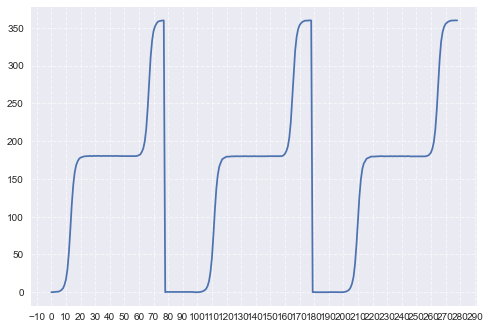

In [139]:
plt.plot(y)
# Customize grid lines
plt.grid(True, which='both', linestyle='--', alpha=0.6)  # Enable grid lines with custom style

# Set more ticks on the x-axis
x_major_locator = MultipleLocator(10)  # Major ticks every 1 unit

# Apply locators to the x-axis
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(x_major_locator)


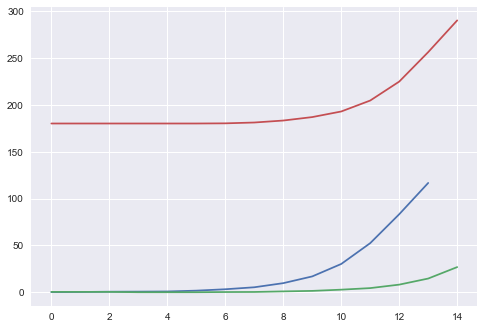

In [145]:
regions = [y[1:15],y[95:110],y[152:167]]
for r in regions:
    plt.plot(r)

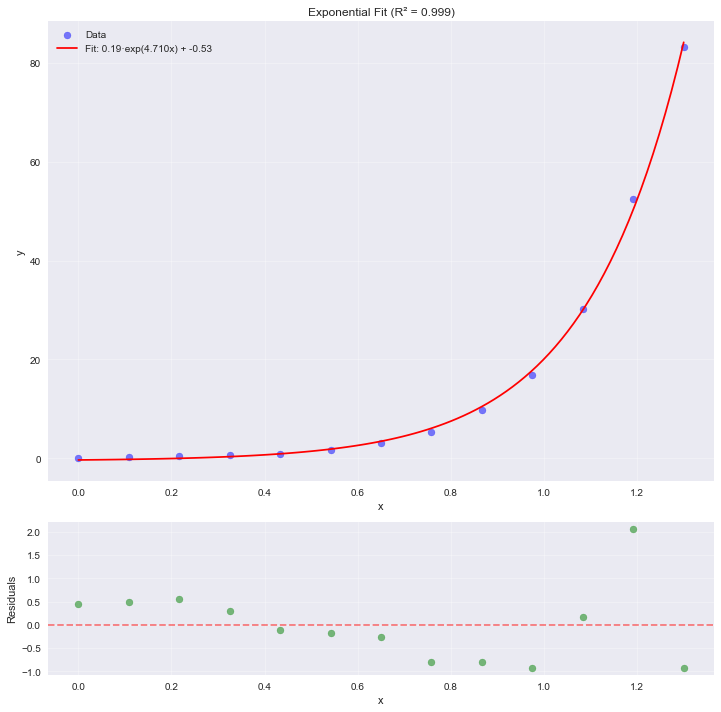

In [125]:
yd = y[1:14]
x = np.linspace(0,0.1*len(yd),len(yd))
params, r2 = fit_exponential(x, yd, offset_type='y')

In [126]:
r2

0.9989421716333423

In [32]:
x

array([0.        , 0.10344828, 0.20689655, 0.31034483, 0.4137931 ,
       0.51724138, 0.62068966, 0.72413793, 0.82758621, 0.93103448,
       1.03448276, 1.13793103, 1.24137931, 1.34482759, 1.44827586,
       1.55172414, 1.65517241, 1.75862069, 1.86206897, 1.96551724,
       2.06896552, 2.17241379, 2.27586207, 2.37931034, 2.48275862,
       2.5862069 , 2.68965517, 2.79310345, 2.89655172, 3.        ])

In [160]:
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from typing import List, Tuple, Set

def robust_exponential_model(x: np.ndarray, y: np.ndarray, p0: List[float] = None) -> np.ndarray:
    """
    More robust exponential model fitting with multiple optimization strategies.
    """
    def exponential_model(x, a, b, c):
        return a * np.exp(b * x) + c
    
    # If no initial guess provided, create one
    if p0 is None:
        p0 = [
            np.max(y) - np.min(y),  # Amplitude
            np.log(np.max(y) / np.min(y)) / (x[-1] - x[0]),  # Growth rate estimate
            np.min(y)  # Offset
        ]
    
    # Multiple optimization attempts with different strategies
    optimization_methods = [
        {'method': 'trf', 'max_nfev': 2000},
        {'method': 'dogbox', 'max_nfev': 2000},
        {'method': 'lm', 'max_nfev': 2000}
    ]
    
    last_error = None
    for method_config in optimization_methods:
        try:
            # Try curve fitting with current method
            popt, pcov = optimize.curve_fit(
                exponential_model, 
                x, 
                y, 
                p0=p0, 
                method=method_config['method'],
                maxfev=method_config['max_nfev']
            )
            return popt
        except (RuntimeError, optimize.OptimizeWarning) as e:
            # Store the last error if all methods fail
            last_error = e
            # Adjust initial guess slightly
            p0[0] *= 1.1
            p0[1] *= 0.9
    
    # If all methods fail, raise the last error
    if last_error:
        raise RuntimeError(f"Exponential fitting failed: {last_error}")
    
    raise RuntimeError("Exponential fitting failed for unknown reasons")

def find_non_overlapping_exponential_regions(x: np.ndarray, y: np.ndarray, 
                                              threshold: float = 0.85, 
                                              min_region_length: int = 5,
                                              max_regions: int = 10) -> List[Tuple[int, int]]:
    """
    Detect non-overlapping exponential regions in time series data.
    
    Parameters:
    -----------
    x : np.ndarray
        Independent variable (typically time)
    y : np.ndarray
        Dependent variable 
    threshold : float, optional
        Minimum R-squared value to consider a region exponential
    min_region_length : int, optional
        Minimum number of points to consider a valid exponential region
    max_regions : int, optional
        Maximum number of regions to detect
    
    Returns:
    --------
    List of tuples containing start and end indices of non-overlapping exponential regions
    """
    def r_squared(y_true, y_pred):
        residuals = y_true - y_pred
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        return 1 - (ss_res / ss_tot)
    
    def exponential_model(x, a, b, c):
        return a * np.exp(b * x) + c
    
    # Normalize data to improve fitting
    y_normalized = (y - np.min(y)) / (np.max(y) - np.min(y))
    
    exponential_regions = []
    used_indices: Set[int] = set()
    
    # Sliding window approach to detect non-overlapping exponential regions
    for window_start in range(len(y) - min_region_length):
        # Skip if any indices in this window have been used
        if any(idx in used_indices for idx in range(window_start, len(y))):
            continue
        
        for window_end in range(window_start + min_region_length, len(y)):
            # Skip if any indices in this window have been used
            if any(idx in used_indices for idx in range(window_start, window_end)):
                break
            
            x_window = x[window_start:window_end]
            y_window = y_normalized[window_start:window_end]
            
            try:
                # Fit exponential model
                popt = robust_exponential_model(x_window, y_window)
                
                # Reconstruct the model with fitted parameters
                y_pred = exponential_model(x_window, *popt)
                
                # Check R-squared
                r2 = r_squared(y_window, y_pred)
                
                if r2 >= threshold and popt[0] > 0:
                    # Mark these indices as used
                    used_indices.update(range(window_start, window_end))
                    
                    exponential_regions.append((window_start, window_end))
                    
                    # Stop if we've found max number of regions
                    if len(exponential_regions) >= max_regions:
                        return exponential_regions
                    
                    # Break inner loop to move to next window start
                    break
            except Exception:
                continue
    
    return exponential_regions

def fit_exponential_regions(x: np.ndarray, y: np.ndarray, 
                             regions: List[Tuple[int, int]]) -> List[dict]:
    """
    Fit exponential model to detected regions with robust parameter estimation.
    """
    def exponential_model(x, a, b, c):
        return a * np.exp(b * x) + c
    
    region_fits = []
    
    for start, end in regions:
        x_region = x[start:end]
        y_region = y[start:end]
        
        try:
            # Robust parameter fitting
            popt = robust_exponential_model(x_region, y_region)
            
            # Compute covariance matrix
            popt, pcov = optimize.curve_fit(
                exponential_model, 
                x_region, 
                y_region, 
                p0=popt
            )
            
            # Calculate parameter uncertainties
            perr = np.sqrt(np.diag(pcov))
            
            region_fits.append({
                'start_index': start,
                'end_index': end,
                'amplitude': popt[0],
                'amplitude_err': perr[0],
                'growth_rate': popt[1],
                'growth_rate_err': perr[1],
                'offset': popt[2],
                'offset_err': perr[2]
            })
        except Exception as e:
            print(f"Fitting failed for region {start}:{end}: {e}")
    
    return region_fits

def average_exponential_parameters(region_fits: List[dict]) -> dict:
    """
    Calculate average parameters across exponential regions.
    """
    # Extract parameters
    amplitudes = [fit['amplitude'] for fit in region_fits]
    growth_rates = [fit['growth_rate'] for fit in region_fits]
    offsets = [fit['offset'] for fit in region_fits]
    
    return {
        'avg_amplitude': np.mean(amplitudes),
        'std_amplitude': np.std(amplitudes),
        'avg_growth_rate': np.mean(growth_rates),
        'std_growth_rate': np.std(growth_rates),
        'avg_offset': np.mean(offsets),
        'std_offset': np.std(offsets)
    }

def analyze_exponential_curves(x: np.ndarray, y: np.ndarray, 
                                threshold: float = 0.85, 
                                min_region_length: int = 5,
                                max_regions: int = 10) -> dict:
    """
    Comprehensive analysis of non-overlapping exponential regions in time series data.
    """
    # Detect non-overlapping exponential regions
    regions = find_non_overlapping_exponential_regions(
        x, y, 
        threshold=threshold, 
        min_region_length=min_region_length,
        max_regions=max_regions
    )
    
    if not regions:
        return {'regions': [], 'average_parameters': None}
    
    # Fit exponential to each region
    region_fits = fit_exponential_regions(x, y, regions)
    
    # Average parameters across regions
    avg_parameters = average_exponential_parameters(region_fits)
    
    return {
        'regions': regions,
        'region_fits': region_fits,
        'average_parameters': avg_parameters
    }



/var/folders/bb/fz0zm3_96tl62820445bgd5w0000gn/T/ipykernel_10646/2836602972.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  np.log(np.max(y) / np.min(y)) / (x[-1] - x[0]),  # Growth rate estimate
/Users/alexleffell/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:424: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x
/var/folders/bb/fz0zm3_96tl62820445bgd5w0000gn/T/ipykernel_10646/2836602972.py:11: RuntimeWarning: invalid value encountered in multiply
  return a * np.exp(b * x) + c
/var/folders/bb/fz0zm3_96tl62820445bgd5w0000gn/T/ipykernel_10646/2836602972.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (ss_res / ss_tot)
/var/folders/bb/fz0zm3_96tl62820445bgd5w0000gn/T/ipykernel_10646/2836602972.py:11: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * x) + c
/Users/alexleffell/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning

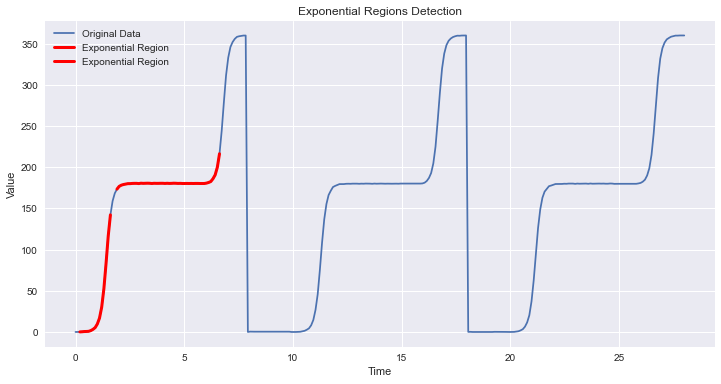

Detected Regions: [(2, 17), (19, 67)]

Region Fits:
{'start_index': 2, 'end_index': 17, 'amplitude': 0.6937363048555001, 'amplitude_err': 0.314479790672465, 'growth_rate': 3.372612037596688, 'growth_rate_err': 0.2842514490063993, 'offset': -5.097375963707008, 'offset_err': 3.0409888953326667}
{'start_index': 19, 'end_index': 67, 'amplitude': -48976.55356982968, 'amplitude_err': nan, 'growth_rate': -4.461556920380695e-05, 'growth_rate_err': nan, 'offset': 49148.78572514932, 'offset_err': nan}

Average Parameters:
{'avg_amplitude': -24487.929916762412, 'std_amplitude': 24488.62365306727, 'avg_growth_rate': 1.686283711013742, 'std_growth_rate': 1.6863283265829458, 'avg_offset': 24571.844174592807, 'std_offset': 24576.941550556512}


In [161]:
# y = df['Test Grid/Caster Angle'].to_list()
x = np.linspace(0,0.1*len(y),len(y))
# Analyze exponential regions
results = analyze_exponential_curves(x, y, min_region_length=15, threshold=0.95)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Original Data')

# Plot detected regions
for region in results['regions']:
    start, end = region
    plt.plot(x[start:end], y[start:end], 'r-', linewidth=3, label='Exponential Region')

plt.title('Exponential Regions Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Print results
print("Detected Regions:", results['regions'])
print("\nRegion Fits:")
for fit in results['region_fits']:
    print(fit)

print("\nAverage Parameters:")
print(results['average_parameters'])

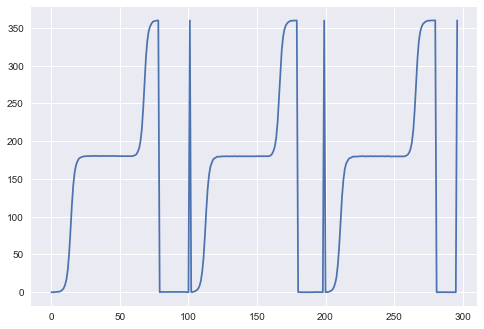

In [150]:
plt.plot(y)

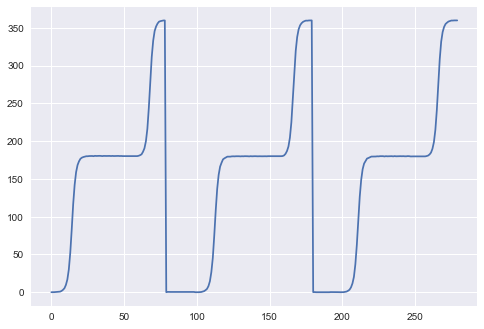

In [157]:
plt.plot(y)

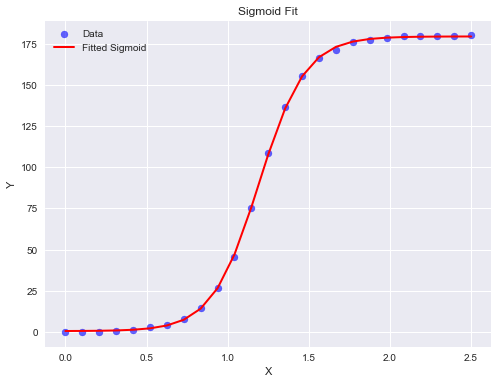

Fitted parameters: a=178.78, b=6.96, c=1.19, d=0.54


In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the sigmoid function
def sigmoid(x, a, b, c, d):
    """
    Sigmoid function.
    Parameters:
        x: Independent variable
        a: Maximum value of the curve
        b: Steepness of the curve
        c: Midpoint (x-value of the sigmoid's center)
        d: Minimum value of the curve (offset)
    """
    return a / (1 + np.exp(-b * (x - c))) + d

# Generate synthetic data (optional, for demonstration)
np.random.seed(0)
x_data = np.linspace(0,0.1*len(y_data),len(y_data))

# Fit the data to the sigmoid function
p0 = [100, 1, 1, 75]  # Initial guesses for a, b, c, d
params, covariance = curve_fit(sigmoid, x_data, y_data, p0)

# Extract fitted parameters
a_fit, b_fit, c_fit, d_fit = params

# Generate fitted curve
y_fit = sigmoid(x_data, a_fit, b_fit, c_fit, d_fit)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, label='Data', color='blue', alpha=0.6)
plt.plot(x_data, y_fit, label='Fitted Sigmoid', color='red', linewidth=2)
plt.legend()
plt.title("Sigmoid Fit")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

# Print fitted parameters
print(f"Fitted parameters: a={a_fit:.2f}, b={b_fit:.2f}, c={c_fit:.2f}, d={d_fit:.2f}")


In [121]:
len(x_data)

24